In [112]:
%load_ext autoreload
%autoreload 2
import dpp
import matplotlib.pyplot as plt
import numpy as np
import torch
from copy import deepcopy
from time import process_time
#torch.set_default_tensor_type(torch.cuda.FloatTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
dpp.data.list_datasets()

['final_batched_high_load_n_400/20210610_23:14_fanout_large_fetched_397_n_400_l_0.01_u_0.01_b_50_w_120',
 'final_batched_high_load_n_400/20210611_00:04_parallel_large_fetched_390_n_400_l_0.01_u_0.01_b_50_w_120',
 'final_batched_high_load_n_400/20210611_00:53_tree_large_fetched_399_n_400_l_0.01_u_0.01_b_50_w_120',
 'final_batched_high_load_n_400/20210611_01:43_fanout_large_fetched_391_n_400_l_0.01_u_0.01_b_50_w_120_rand',
 'final_batched_high_load_n_400/20210611_02:33_parallel_large_fetched_383_n_400_l_0.01_u_0.01_b_50_w_120_rand',
 'final_batched_high_load_n_400/20210611_03:23_tree_large_fetched_398_n_400_l_0.01_u_0.01_b_50_w_120_rand',
 'final_batched_high_load_n_400/20210611_04:13_fanout_small_fetched_384_n_400_l_0.0001_u_0.0001_b_50_w_120',
 'final_batched_high_load_n_400/20210611_07:23_fanout_small_fetched_394_n_400_l_0.0001_u_0.0001_b_50_w_120_rand',
 'final_batched_high_load_n_400/20210611_11:32_parallel_small_fetched_397_n_400_l_0.0001_u_0.0001_b_50_w_120',
 'final_batched_high_

In [114]:
# Config
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
dataset_name = "final_low_load_n_1000/20210605_02:55_sequence_fetched_1000_n_1000_l_0.3_u_0.6_rand"  # run dpp.data.list_datasets() to see the list of available datasets

# Model config
context_size = 64                 # Size of the RNN hidden vector
mark_embedding_size = 32          # Size of the mark embedding (used as RNN input)
coldstart_feature = True          # Model feature indicating if the last invocation was a cold start
coldstart_embedding_size = 32     # Size of the cold start feature embedding (used as RNN input)
num_mix_components = 16           # Number of components for a mixture model
rnn_type = "GRU"                  # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}
mae_loss = False                  # Evaluate the predicted time for the next invocation with the mean absolute error.
                                  # Therefore, the model predicts \tau directly instead of the PDF f^*(\tau) (see 'TruncNorm' in the paper)

# Training config
batch_size = 64        # Number of sequences in a batch
regularization = 1e-5  # L2 regularization parameter
learning_rate = 1e-3   # Learning rate for Adam optimizer
max_epochs = 200       # For how many epochs to train
display_step = 5       # Display training statistics after every display_step
patience = 20          # After how many consecutive epochs without improvement of val loss to stop training

In [115]:
# Load the data
dataset = dpp.data.load_dataset(dataset_name)
d_train, d_val, d_test = dataset.train_val_test_split(seed=seed)

dl_train = d_train.get_dataloader(batch_size=batch_size, shuffle=True)
dl_val = d_val.get_dataloader(batch_size=batch_size, shuffle=False)
dl_test = d_test.get_dataloader(batch_size=batch_size, shuffle=False)

In [116]:
# Define the model
print('Building model...')
mean_log_inter_time, std_log_inter_time = d_train.get_inter_time_statistics()

model = dpp.models.LogNormMix(
    num_marks=d_train.num_marks,
    mean_log_inter_time=mean_log_inter_time,
    std_log_inter_time=std_log_inter_time,
    context_size=context_size,
    mark_embedding_size=mark_embedding_size,
    rnn_type=rnn_type,
    num_mix_components=num_mix_components,
    coldstart_feature=coldstart_feature,
    coldstart_embedding_size=coldstart_embedding_size
)
opt = torch.optim.Adam(model.parameters(), weight_decay=regularization, lr=learning_rate)

Building model...


In [117]:
# Training
def inter_time_errors(batch):
    predicted_inter_times, _ = model.predict(batch)
    errors = predicted_inter_times - batch.inter_times
    #indices = torch.nonzero(batch.mask, as_tuple=True)
    #return errors[indices]
    index = torch.nonzero(batch.mask.sum(dim=0), as_tuple=True)[0]  # Only works if all sequences have the same length.
    return errors.index_select(dim=1, index=index)

def correct_predicted_marks(batch):
    _, predicted_marks = model.predict(batch)
    correct_predictions = predicted_marks == batch.marks
    index = torch.nonzero(batch.mask.sum(dim=0), as_tuple=True)[0]  # Only works if all sequences have the same length.
    return correct_predictions.index_select(dim=1, index=index)

def aggregate_loss_over_dataloader(dl, mae_loss):
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dl:
            if mae_loss:
                total_loss += (inter_time_errors(batch).abs().sum() - model.mark_log_prob(batch).sum()).item()
            else:
                total_loss += -model.log_prob(batch).sum().item()
            total_count += batch.mask.sum().item()
    return total_loss / total_count

def aggregate_mark_nll_over_dataloader(dl):
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dl:
            total_loss += -model.mark_log_prob(batch).sum().item()
            total_count += batch.mask.sum().item()
    return total_loss / total_count

def aggregate_mae_over_dataloader(dl):
    total_mae = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dl:
            total_mae += inter_time_errors(batch).abs().sum().item()
            total_count += batch.mask.sum().item()
    return total_mae / total_count

def aggregate_accuracy_over_dataloader(dl):
    total_correct_predictions = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dl:
            total_correct_predictions += correct_predicted_marks(batch).sum().item()
            total_count += batch.mask.sum().item()
    return total_correct_predictions / total_count

def inter_time_errors_over_dataloader(dl):
    result = torch.Tensor()
    with torch.no_grad():
        for batch in dl:
            result = torch.cat([result, inter_time_errors(batch)], dim=0)
    return result

def correct_predicted_marks_over_dataloader(dl):
    result = torch.Tensor()
    with torch.no_grad():
        for batch in dl:
            result = torch.cat([result, correct_predicted_marks(batch)], dim=0)
    return result

In [118]:
# Traning
print('Starting training...')

impatient = 0
best_loss = np.inf
best_model = deepcopy(model.state_dict())
start_processtime = process_time()

for epoch in range(max_epochs):
    model.train()
    for batch in dl_train:
        opt.zero_grad()
        loss = 0.0
        if mae_loss:
            loss = inter_time_errors(batch).abs().mean() - model.mark_log_prob(batch).mean()
        else:
            loss = -model.log_prob(batch).mean()
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        loss_val = aggregate_loss_over_dataloader(dl_val, mae_loss)
        mark_nll_val = aggregate_mark_nll_over_dataloader(dl_val)
        mae_val = aggregate_mae_over_dataloader(dl_val)
        acc_val = aggregate_accuracy_over_dataloader(dl_val)

    if (best_loss - loss_val) < 1e-4:
        impatient += 1
        if loss_val < best_loss:
            best_loss = loss_val
            best_model = deepcopy(model.state_dict())
    else:
        best_loss = loss_val
        best_model = deepcopy(model.state_dict())
        impatient = 0

    if impatient >= patience:
        print(f'Breaking due to early stopping at epoch {epoch}')
        break

    if epoch % display_step == 0:
        print(f"Epoch {epoch:4d} of {max_epochs:4d}: loss_train_last_batch = {loss.item():.3f}, loss_val = {loss_val:.3f}, mark_nll_val = {mark_nll_val:.3f}, mae_val = {mae_val:.3f}, acc_val = {acc_val:.3f}")

trained_processtime = process_time() - start_processtime
print(f"Trained process time: {trained_processtime:.3f}s\n"
      f"Trained epochs: {epoch+1}")

Starting training...
Epoch    0 of  200: loss_train_last_batch = 105.460, loss_val = 10.466, mark_nll_val = 2.023, mae_val = 388.785, acc_val = 0.700
Epoch    5 of  200: loss_train_last_batch = 71.396, loss_val = 7.166, mark_nll_val = 1.155, mae_val = 388.933, acc_val = 1.000
Epoch   10 of  200: loss_train_last_batch = 61.669, loss_val = 6.168, mark_nll_val = 0.519, mae_val = 388.908, acc_val = 1.000
Epoch   15 of  200: loss_train_last_batch = 56.939, loss_val = 5.744, mark_nll_val = 0.193, mae_val = 388.905, acc_val = 1.000
Epoch   20 of  200: loss_train_last_batch = 55.150, loss_val = 5.543, mark_nll_val = 0.095, mae_val = 388.904, acc_val = 1.000
Epoch   25 of  200: loss_train_last_batch = 54.806, loss_val = 5.518, mark_nll_val = 0.057, mae_val = 388.902, acc_val = 1.000
Epoch   30 of  200: loss_train_last_batch = 54.290, loss_val = 5.484, mark_nll_val = 0.039, mae_val = 388.902, acc_val = 1.000
Epoch   35 of  200: loss_train_last_batch = 55.294, loss_val = 5.506, mark_nll_val = 0.0

In [119]:
# Evaluation
model.load_state_dict(best_model)
model.eval()
# Evaluation via total loss (= NLL_time + NLL_mark, if mae_loss=False, = MAE_time + NLL_mark, else)
with torch.no_grad():
    final_loss_train = aggregate_loss_over_dataloader(dl_train, mae_loss)
    final_loss_val = aggregate_loss_over_dataloader(dl_val, mae_loss)
    final_loss_test = aggregate_loss_over_dataloader(dl_test, mae_loss)
s = "NLL_time + NLL_mark"
if mae_loss:
    s = "MAE_time + NLL_mark"
print(f'Total loss (= {s}):\n'
    f'- Train: {final_loss_train:.3f}\n'
    f'- Val:   {final_loss_val:.3f}\n'
    f'- Test:  {final_loss_test:.3f}')
# Evaluation via mark negative log-likelihood
with torch.no_grad():
    final_mark_nll_train = aggregate_mark_nll_over_dataloader(dl_train)
    final_mark_nll_val = aggregate_mark_nll_over_dataloader(dl_val)
    final_mark_nll_test = aggregate_mark_nll_over_dataloader(dl_test)
print(f'Mark negative log-likelihood (NLL_mark):\n'
    f'- Train: {final_mark_nll_train:.3f}\n'
    f'- Val:   {final_mark_nll_val:.3f}\n'
    f'- Test:  {final_mark_nll_test:.3f}')
# Evaluation via accuracy
with torch.no_grad():
    final_acc_train = aggregate_accuracy_over_dataloader(dl_train)
    final_acc_val = aggregate_accuracy_over_dataloader(dl_val)
    final_acc_test = aggregate_accuracy_over_dataloader(dl_test)
print(f'Accuracy:\n'
    f'- Train: {final_acc_train:.3f}\n'
    f'- Val:   {final_acc_val:.3f}\n'
    f'- Test:  {final_acc_test:.3f}')
if mae_loss:
    # Evaluation via mean absolute error
    with torch.no_grad():
        final_mae_train = aggregate_mae_over_dataloader(dl_train)
        final_mae_val = aggregate_mae_over_dataloader(dl_val)
        final_mae_test = aggregate_mae_over_dataloader(dl_test)
    print(f'Mean absolute error (MAE):\n'
        f'- Train: {final_mae_train:.3f}\n'
        f'- Val:   {final_mae_val:.3f}\n'
        f'- Test:  {final_mae_test:.3f}')

Total loss (= NLL_time + NLL_mark):
- Train: 5.446
- Val:   5.424
- Test:  5.428
Mark negative log-likelihood (NLL_mark):
- Train: 0.013
- Val:   0.012
- Test:  0.012
Accuracy:
- Train: 1.000
- Val:   1.000
- Test:  1.000


/usr/local/anaconda3/envs/tppfaas/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


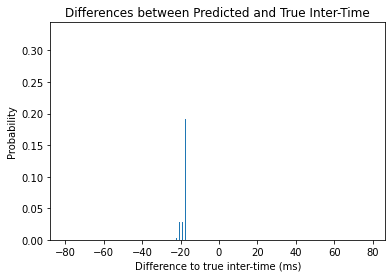

In [120]:
# Evaluation of differences between predicted and true inter-time
model.load_state_dict(best_model)
model.eval() 

plt.hist(inter_time_errors_over_dataloader(dl_test).numpy(), bins=100, label="test", range=(-80, 80), density=True)
plt.ylabel("Probability")
plt.xlabel("Difference to true inter-time (ms)")
plt.title("Differences between Predicted and True Inter-Time")
plt.show()